In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using ReactiveMP, GraphPPL, RxInfer, Distributions, LinearAlgebra,Plots, Random
using BenchmarkTools
import KernelFunctions: Matern52Kernel, with_lengthscale

  ** incremental compilation may be fatally broken for this module **



  ** incremental compilation may be fatally broken for this module **



## Test with fixed hyperparameters

In [3]:
Random.seed!(3)
xmin, xmax = -3, 3  # Bounds of the data
N = 200# Number of samples
xtrain = sort(rand(Uniform(xmin, xmax), N))
xtest = collect(range(xmin - 0.1, xmax + 0.1; length=600));
xtest = sort(vcat(xtest,xtrain))
precision = 100
ytrain = sinc.(xtrain) + randn(N) * sqrt(1/precision);
f_true = sinc.(xtest);

k_func(θ) =  with_lengthscale(Matern52Kernel(),θ) 
meanfunc   = (x) -> 0.0;
θ_init = 1.0 #our initial lengthscale
log_θ_init = log(θ_init)

cov_strategy = CovarianceMatrixStrategy(SoR(50))

CovarianceMatrixStrategy{DeterministicInducingConditional{MersenneTwister}}(DeterministicInducingConditional{MersenneTwister}(50, MersenneTwister(1), [1.0;;], [1.0;;], [1.0;;], [1.0;;], ReactiveMP.GPCache(Dict{Tuple{Symbol, Tuple{Int64, Int64}}, Matrix{Float64}}(), Dict{Tuple{Symbol, Int64}, Vector{Float64}}())))

In [4]:
# test new thing
@model function gp_regress(n,kernelfunc,meanfunc,train,test,log_θ,strategy)
    y = datavar(Float64,n)
    x = randomprocess(test,train,strategy)
    ### change here 
    x ~ GaussianProcess(meanfunc,kernelfunc, log_θ)
    #######
    γ ~ GammaShapeRate(.01,0.01)
    for i=1:n 
        y[i] ~ NormalMeanPrecision(x, γ) where {meta=ProcessMeta(i)}
    end
end

In [5]:
@constraints function gpconstraints()   
    q(x,γ) = q(x)q(γ)
end

gpconstraints (generic function with 1 method)

In [10]:
nits = 10
iresult = inference(
    model = gp_regress(length(ytrain), k_func, meanfunc, xtrain,xtest,log_θ_init,CovarianceMatrixStrategy(SoR(50))),
    initmarginals = (γ = GammaShapeRate(0.01,0.01),),
    constraints = gpconstraints(),
    iterations = nits,  
    data  = (y = ytrain,),
    # free_energy = true,
    showprogress = true
)

Progress:  20%|████████▎                                |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Inference results:
  Posteriors       | available for (γ, x)


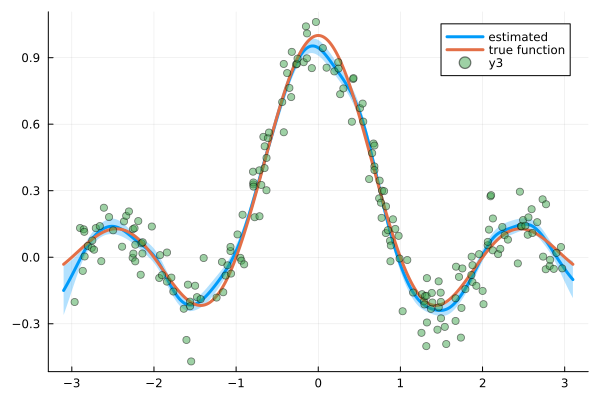

In [8]:
#SoR
plot(xtest,mean(iresult.posteriors[:x][end].finitemarginal),ribbon=sqrt.(diag(cov(iresult.posteriors[:x][end].finitemarginal))),linewidth=3.0,label="estimated",fillalpha=0.3)
plot!(xtest,f_true,linewidth=3.0,label="true function")
scatter!(xtrain,ytrain, alpha=0.5)

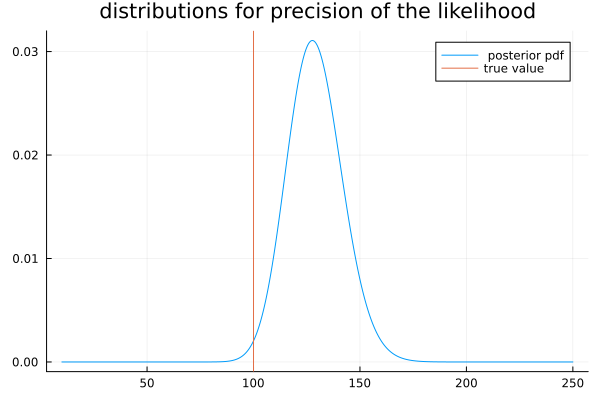

In [10]:
from  = 10
to    = 250
t     = collect(from:0.1:to)

plot(t,pdf.(iresult.posteriors[:γ][end],t),fillalpha=0.2,title="distributions for precision of the likelihood",label=" posterior pdf")
#     plot!(t, pdf.(GammaShapeRate(0.001,0.001),t),fillalpha=0.2,label="prior pdf")
vline!([precision],label="true value")
# gif(anim, "anim_fps15.gif", fps = 15)

In [11]:
#After improvement
@benchmark inference(
    model = gp_regress(length($ytrain), $k_func, $meanfunc, $xtrain,$xtest,$log_θ_init, CovarianceMatrixStrategy(SoR(50))),
    initmarginals = (γ = GammaShapeRate(0.01,0.01),),
    constraints = gpconstraints(),
    iterations = $nits,  
    data  = (y = $ytrain,)
)

BenchmarkTools.Trial: 92 samples with 1 evaluation.
 Range (min … max):  47.770 ms … 73.994 ms  ┊ GC (min … max): 0.00% … 10.23%
 Time  (median):     54.103 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   54.878 ms ±  4.245 ms  ┊ GC (mean ± σ):  2.73% ±  4.89%

          ▂▂      █ ▆                                          
  ▄▁▁▁▅▁▄▇██▇▄██▇▅█▅█▄▇█▅▁▇▇▄▇▅▄▇▁▁▅▅▄▁▁▄▁▁▄▁▅▁▁▁▄▄▁▁▁▁▁▁▁▁▁▄ ▁
  47.8 ms         Histogram: frequency by time          68 ms <

 Memory estimate: 27.00 MiB, allocs estimate: 183690.

In [ ]:
# BenchmarkTools.Trial: 18 samples with 1 evaluation.
#  Range (min … max):  241.086 ms … 333.323 ms  ┊ GC (min … max): 7.89% … 7.88%
#  Time  (median):     277.008 ms               ┊ GC (median):    8.16%
#  Time  (mean ± σ):   280.628 ms ±  23.459 ms  ┊ GC (mean ± σ):  8.72% ± 2.64%

#   ▁       ▁▁  ▁ ▁     ▁▁ ██  ▁▁        ▁▁      ▁  ▁           ▁  
#   █▁▁▁▁▁▁▁██▁▁█▁█▁▁▁▁▁██▁██▁▁██▁▁▁▁▁▁▁▁██▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁█ ▁
#   241 ms           Histogram: frequency by time          333 ms <

#  Memory estimate: 166.20 MiB, allocs estimate: 251928.

In [ ]:
# BenchmarkTools.Trial: 86 samples with 1 evaluation. (with old extractmatrix! function and old structure of SoR, but this is incorrect for Kuu)
#  Range (min … max):  51.435 ms … 89.782 ms  ┊ GC (min … max): 0.00% … 12.28%
#  Time  (median):     55.008 ms              ┊ GC (median):    0.00%
#  Time  (mean ± σ):   58.720 ms ±  8.291 ms  ┊ GC (mean ± σ):  2.94% ±  5.29%

#   ▄▁█▇▅▁                                                       
#   ███████▅▃▃▅▅▃▃▁█▅▅▃▆▃▅▆▁▁▁▁▅▃▃▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▃▃ ▁
#   51.4 ms         Histogram: frequency by time        88.4 ms <

#  Memory estimate: 24.85 MiB, allocs estimate: 183630.

In [ ]:
# BenchmarkTools.Trial: 18 samples with 1 evaluation. (store all matrices in cache)
#  Range (min … max):  259.284 ms … 377.416 ms  ┊ GC (min … max): 0.00% … 2.09%
#  Time  (median):     283.657 ms               ┊ GC (median):    0.00%
#  Time  (mean ± σ):   286.741 ms ±  24.269 ms  ┊ GC (mean ± σ):  1.09% ± 1.24%

#           ▃ ▃ ██ ▃                                               
#   ▇▁▁▇▁▁▁▁█▇█▁██▇█▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇ ▁
#   259 ms           Histogram: frequency by time          377 ms <

#  Memory estimate: 70.95 MiB, allocs estimate: 173605.

In [ ]:
# BenchmarkTools.Trial: 19 samples with 1 evaluation. (store all matrices in cache)
#  Range (min … max):  222.678 ms … 325.231 ms  ┊ GC (min … max): 0.00% … 2.10%
#  Time  (median):     242.620 ms               ┊ GC (median):    0.00%
#  Time  (mean ± σ):   267.698 ms ±  41.383 ms  ┊ GC (mean ± σ):  1.11% ± 1.23%

#        █                                                ▃     ▃  
#   ▇▁▇▇▁█▇▇▁▇▁▇▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇█▁▇▇▁▁█ ▁
#   223 ms           Histogram: frequency by time          325 ms <

#  Memory estimate: 71.02 MiB, allocs estimate: 173625.

In [ ]:
# BenchmarkTools.Trial: 17 samples with 1 evaluation. (store all matrices in cache, add extractmatrix_change! function)
#  Range (min … max):  263.068 ms … 426.410 ms  ┊ GC (min … max): 0.00% … 1.43%
#  Time  (median):     286.382 ms               ┊ GC (median):    0.00%
#  Time  (mean ± σ):   309.877 ms ±  46.601 ms  ┊ GC (mean ± σ):  1.21% ± 1.36%

#        ▃  █           ▃                 ▃                        
#   ▇▁▁▇▇█▇▁█▁▁▇▇▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇ ▁
#   263 ms           Histogram: frequency by time          426 ms <

#  Memory estimate: 70.99 MiB, allocs estimate: 173524.

In [ ]:
# BenchmarkTools.Trial: 76 samples with 1 evaluation. (store all matrices in structures, use cache for prediction function only)
#  Range (min … max):  48.972 ms … 135.752 ms  ┊ GC (min … max): 0.00% … 0.00%
#  Time  (median):     61.711 ms               ┊ GC (median):    0.00%
#  Time  (mean ± σ):   65.985 ms ±  14.494 ms  ┊ GC (mean ± σ):  2.87% ± 4.84%

#     ▂ ▅█▅▅    ▂ █        ▂   ▂              ▂                   
#   ▅▁██████▅▁█▅█▁██▁██▁▁▁▅█▅▁██▁▅▅▅▅▅██▁▁▁▁▅▁█▁▅▁██▁▁▅▁▅▁█▅▁▁▁▅ ▁
#   49 ms           Histogram: frequency by time         92.9 ms <

#  Memory estimate: 30.80 MiB, allocs estimate: 183764.

In [ ]:
#store all matrices in cache, and use get! to get the value of the keys
# BenchmarkTools.Trial: 18 samples with 1 evaluation.
#  Range (min … max):  247.235 ms … 327.485 ms  ┊ GC (min … max): 0.00% … 2.26%
#  Time  (median):     295.323 ms               ┊ GC (median):    2.15%
#  Time  (mean ± σ):   289.753 ms ±  33.660 ms  ┊ GC (mean ± σ):  1.90% ± 0.96%

#   ▁▁  ▁▁▁▁▁  ▁                ▁               ▁       ▁   █▁▁▁█  
#   ██▁▁█████▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁█▁▁▁█████ ▁
#   247 ms           Histogram: frequency by time          327 ms <

#  Memory estimate: 120.01 MiB, allocs estimate: 173575.

In [ ]:
#(store all matrices in structures, use cache for prediction function only, dont use mul_A_B_ABt! for extractmatrix function)
# BenchmarkTools.Trial: 87 samples with 1 evaluation.
#  Range (min … max):  50.816 ms … 75.346 ms  ┊ GC (min … max): 0.00% … 0.00%
#  Time  (median):     56.890 ms              ┊ GC (median):    0.00%
#  Time  (mean ± σ):   57.643 ms ±  4.889 ms  ┊ GC (mean ± σ):  3.12% ± 5.06%

#         ▂             █                                        
#   ▅▅▁▅▅▄█▅█▄█▇█▄▅█▅▅▅██▄▇▇▅▄▁▄▁▅▁▄▁▄▁▁▄▁▄▁▅▁▁▄▅▄▅▁▁▁▄▁▁▁▁▁▄▁▄ ▁
#   50.8 ms         Histogram: frequency by time        70.7 ms <

#  Memory estimate: 30.80 MiB, allocs estimate: 183764.

In [ ]:
# BenchmarkTools.Trial: 89 samples with 1 evaluation.
#  Range (min … max):  45.906 ms … 66.567 ms  ┊ GC (min … max): 0.00% … 0.00%
#  Time  (median):     55.496 ms              ┊ GC (median):    0.00%
#  Time  (mean ± σ):   56.213 ms ±  4.285 ms  ┊ GC (mean ± σ):  2.68% ± 4.85%

#                    ▂   █▄▂         ▂                           
#   ▄▁▁▁▁▁▁▁▁▁▁▄▄▄▁███▁█▆████▄█▆█▆████▄▄▆▄▁▆▁▁▁▄██▆▆▄▁▄▁▄▁▆▄▁▄▄ ▁
#   45.9 ms         Histogram: frequency by time        65.9 ms <

#  Memory estimate: 27.00 MiB, allocs estimate: 183680.

In [ ]:
# BenchmarkTools.Trial: 91 samples with 1 evaluation.
#  Range (min … max):  46.763 ms … 77.768 ms  ┊ GC (min … max): 0.00% … 12.48%
#  Time  (median):     53.664 ms              ┊ GC (median):    0.00%
#  Time  (mean ± σ):   55.322 ms ±  4.933 ms  ┊ GC (mean ± σ):  2.90% ±  5.53%

#                 ▃▂▆ █ ▃                                        
#   ▄▁▁▄▁▄▁▅▁▅▁▅█▅███▇█▅█▅▇▅▇▁▅▄▄▄▇▅▇▁▁▄▁▁▁▅▄▁▁▅▄▄▁▁▁▄▁▁▅▄▁▁▁▁▄ ▁
#   46.8 ms         Histogram: frequency by time        68.4 ms <

#  Memory estimate: 27.00 MiB, allocs estimate: 183680.

In [ ]:
function sor(gpstrategy::CovarianceMatrixStrategy{<:DeterministicInducingConditional}, kernelfunc, meanfunc, xtrain, xtest, y, x_u)
    """
    gpstrategy: contains n_induing, rng and GPCache
    """
    cache = gpstrategy.strategy.cache 
    


    Kfu = kernelmatrix!(cache, :Kfu, kernelfunc,xtest,x_u) # cross covariance K_*u between test and inducing points 
    Σ = gpstrategy.strategy.Σ
    Kutrain = gpstrategy.strategy.Kuf 
    invΛ = gpstrategy.strategy.invΛ

    xtrain_transformed = getcache(cache, (:xtrain, length(xtrain)))
    xtest_transformed = getcache(cache, (:xtest, length(xtest)))

    map!(meanfunc, xtest_transformed, xtest) # xtest = meanfunc.(xtest)
    map!((y,x) -> y - meanfunc(x), xtrain_transformed, y, xtrain) # xtrain_transformed = y .- meanfunc(xtrain)

    result1 = getcache(cache, (:result1, size(invΛ,1)))
    result2 = getcache(cache, (:result2, size(Kutrain,1)))
    result3 = getcache(cache, (:result3, size(Σ,1)))
    result4 = getcache(cache, (:result4, size(Kfu,1)))

    mul!(result1, invΛ, xtrain_transformed)
    mul!(result2, Kutrain, result1)
    mul!(result3, Σ, result2)
    mul!(result4, Kfu, result3)

    μ_SOR = xtest_transformed + result4
    Σ_SOR = mul_A_B_At!(cache, Kfu, Σ)

    return μ_SOR, Σ_SOR
end

In [ ]:
function kernelmatrix!(cache::GPCache, label::Symbol, kernel, x, y) 
    result = getcache(cache, (label, (length(x), length(y))))
    return kernelmatrix!(result, kernel, x, y)
end

In [ ]:
function extractmatrix!(gpstrategy::CovarianceMatrixStrategy{<:DeterministicInducingConditional}, kernel, x_train, Σ_noise, x_induc)
    gpcache = gpstrategy.cache

    Kuu = kernelmatrix!(gpcache, :Kuu, kernel, x_induc, x_induc)
    Kuf = kernelmatrix!(gpcache, :Kuf, kernel, x_induc, x_train)
    get!(gpcache.cache_matrices, (:invΛ, (size(Σ_noise,1),size(Σ_noise,1))), inv(Diagonal(Σ_noise)))

    invΛ = gpcache.cache_matrices[(:invΛ, (size(Σ_noise,1),size(Σ_noise,1)))]
    Σ = Kuu + mul_A_B_At!(gpcache, Kuf, invΛ)
    gpcache.cache_matrices[(:Σ, (length(x_induc),length(x_induc)))] = Σ
    return gpstrategy
end 

In [ ]:
#use the below function to create a new vector/matrix
function getcache(cache::GPCache, label::Tuple{Symbol, Tuple{Int, Int}})
    return get!(() -> Matrix{Float64}(undef, label[2]), cache.cache_matrices, label)
end
invΛ = inv(Diagonal(Σ_noise))

In [4]:
struct MyCache 
    cache:: Dict{Symbol, Matrix{Float64}}
end
MyCache() = MyCache(Dict{Symbol, Matrix{Float64}}())
function getcache(cache::GPCache, label::Tuple{Symbol, Tuple{Int, Int}})
    return get!(() -> Matrix{Float64}(undef, label[2]), cache.cache_matrices, label)
end

UndefVarError: UndefVarError: GPCache not defined

In [2]:
mycache = MyCache()

MyCache(Dict{Symbol, Matrix{Float64}}())

In [4]:
get!(mycache.cache,:matrix1, Matrix{Float64}(undef,2,2))

2×2 Matrix{Float64}:
 2.20288e-314  NaN
 5.546e-320      0.0

In [5]:
mycache.cache

Dict{Symbol, Matrix{Float64}} with 1 entry:
  :matrix1 => [2.20288e-314 NaN; 5.546e-320 0.0]